In [1]:
import requests
import io
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tqdm.notebook import tqdm
from matplotlib import ticker
plt.rcParams['font.family'] = 'Arial Unicode MS'

/Users/hoover/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### 選股策略

In [2]:
# 先不管這些策略

# (月初)本益比 < 20
# 平均成交筆數 > 2,000

In [3]:
data_readexcel = pd.read_excel('/Users/hoover/Documents/Github/TW Stock/TW_Stock_STprice.xlsx',index_col=0 ,sheet_name=None)
data = data_readexcel
data

{'20240102':           成交股數   成交筆數       成交金額     開盤價     最高價     最低價     收盤價  漲跌價差  \
 證券代號                                                                     
 0050   6283610  10013  848793104  135.60  135.95  134.65  134.90  0.55   
 0051     64969    313    4773744   73.65   73.80   73.20   73.45  0.20   
 0052    459461    487   59030788  129.40  129.40  127.95  128.45  0.95   
 0053     12197     21     868663   71.60   71.60   71.00   71.25  0.40   
 0055    299293    242    7218369   24.12   24.17   24.06   24.13  0.01   
 ...        ...    ...        ...     ...     ...     ...     ...   ...   
 9944    132686    150    2685810   20.20   20.30   20.20   20.25  0.05   
 9945  15196853   8077  590772910   37.95   39.35   37.80   39.25  1.50   
 9946    470703    251    9771854   20.40   21.00   20.35   21.00  0.60   
 9955    173540    222    4229761   24.65   24.65   24.20   24.30  0.10   
 9958   5235083   3954  925009116  176.50  180.50  173.50  173.50  1.00   
 
       最後揭示

####  3545敦泰 日價差交易策略

In [4]:
stock = '3545'

In [5]:
q_shares = pd.DataFrame({a:b.loc[[stock],'成交股數'] for a,b in data.items()}).transpose()
open = pd.DataFrame({a:b.loc[[stock],'開盤價'] for a,b in data.items()}).transpose()
high = pd.DataFrame({a:b.loc[[stock],'最高價'] for a,b in data.items()}).transpose()
low = pd.DataFrame({a:b.loc[[stock],'最低價'] for a,b in data.items()}).transpose()
close = pd.DataFrame({a:b.loc[[stock],'收盤價'] for a,b in data.items()}).transpose()
df = pd.concat([q_shares, open, high, low, close], axis=1)
df.columns = ['成交股數', 'Open', 'High', 'Low', 'Close']
df["Return"]=df["Close"].pct_change()
df.head()

,成交股數,Open,High,Low,Close,Return
20240102,4053840,112.5,112.5,107.5,107.5,NaN
20240103,3267986,107.0,108.5,105.0,106.0,-0.013953
20240104,2166412,106.0,107.0,104.0,106.0,0.000000
20240105,2421434,106.0,108.5,105.5,106.5,0.004717
20240108,2063913,107.0,108.0,104.0,104.0,-0.023474


In [6]:
df['Close_y'] = df["Close"].shift(1)
df['range -%'] = round((df['Low'] - df['Open']) / df['Open'], 2)
df['range +%'] = round((df['High'] - df['Open']) / df['Open'], 2)
df['range %'] = round((df['High'] - df['Low']) / df['Open'], 2)
df['range $'] = df['High'] - df['Low']
df.drop(df.index[0], inplace=True)
df.index = pd.to_datetime(df.index)
df

,成交股數,Open,High,Low,Close,Return,Close_y,range -%,range +%,range %,range $
2024-01-03,3267986,107.0,108.5,105.0,106.0,-0.013953,107.5,-0.02,0.01,0.03,3.5
2024-01-04,2166412,106.0,107.0,104.0,106.0,0.000000,106.0,-0.02,0.01,0.03,3.0
2024-01-05,2421434,106.0,108.5,105.5,106.5,0.004717,106.0,-0.00,0.02,0.03,3.0
2024-01-08,2063913,107.0,108.0,104.0,104.0,-0.023474,106.5,-0.03,0.01,0.04,4.0
2024-01-09,2755185,105.0,105.0,102.0,103.5,-0.004808,104.0,-0.03,0.00,0.03,3.0
2024-01-10,3032074,104.0,105.5,102.0,105.0,0.014493,103.5,-0.02,0.01,0.03,3.5
2024-01-11,2085842,105.0,105.5,103.5,105.0,0.000000,105.0,-0.01,0.00,0.02,2.0
2024-01-12,1695500,104.5,105.0,102.5,103.0,-0.019048,105.0,-0.02,0.00,0.02,2.5
2024-01-15,2838970,103.5,105.5,102.0,102.5,-0.004854,103.0,-0.01,0.02,0.03,3.5
2024-01-16,2684407,102.5,102.5,100.0,101.0,-0.014634,102.5,-0.02,0.00,0.02,2.5


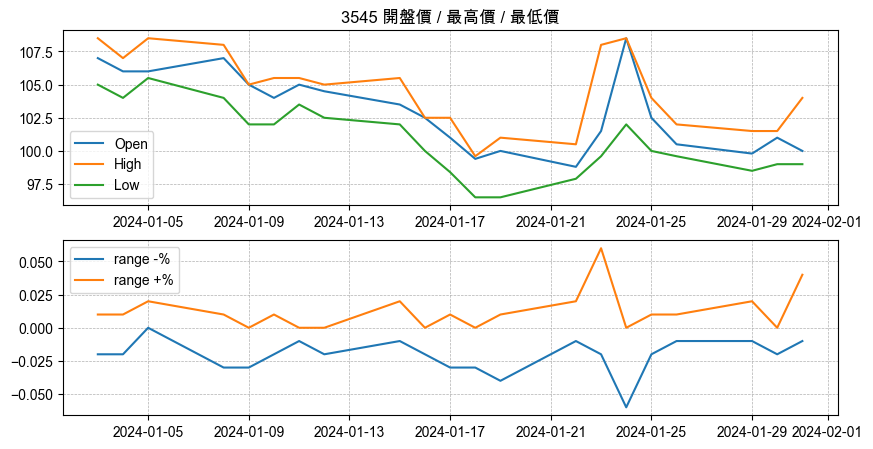

In [7]:
fig, (ax, ax2)  = plt.subplots(nrows=2, figsize=(10,5), sharex=False)

ax.plot(df[['Open', 'High', 'Low']])
ax.legend(['Open', 'High', 'Low'])
ax.grid(linestyle='--', linewidth=0.5)
ax.set_title(stock + ' 開盤價 / 最高價 / 最低價')

ax2.plot(df[['range -%', 'range +%']])
ax2.legend(['range -%', 'range +%'])
ax2.grid(linestyle='--', linewidth=0.5)

plt.show()

In [8]:
def strat01(data, init_holding, init_balance):
    df = data
    # 初始持有證券價值
    init_value = init_holding * df.iloc[0,:]['Close'] * 1000
    # 初始持有張數
    holding = [init_holding]
    # 初始資金
    balance = [init_balance]
    # 交易手續費(買、賣價各0.1425%)
    fee_rate = 0.001425
    # 證交稅(賣出價格0.3%)
    tax_rate = 0.003

    buy, sell, profit, fee, tax, expense, close_value, balance_total = [], [], [], [], [], [], [], []
    cum_transaction = [0]
    cum_expense = [0]

    for date in df.index:
        #一些變數設置
        hold = holding[-1]
        bal = balance[-1]
        buy_, sell_, fee_, tax_, exp_ = [0, 0, 0, 0, 0]
        high = df.loc[date, 'High']
        close_y = df.loc[date, 'Close_y']
        low = df.loc[date, 'Low']
        up =  high - close_y
        down = close_y - low

        if down >= 2.5:                                   #跌2.5塊，買1張
            buy_ += 1
            hold += 1
            bal -= 1 * (close_y - 2.5) * 1000             #花費$(close_y-2.5)買1張=1000股
            fee_ += 1 * (close_y - 2.5) * 1000 * fee_rate
        if down >= 6:                                   #跌6塊，買1張
            buy_ += 1
            hold += 1
            bal -= 1 * (close_y - 6) * 1000             #花費$(close_y-6)買1張=1000股
            fee_ += 1 * (close_y - 6) * 1000 * fee_rate
        if down >= 9:                                   #跌9塊，買2張
            buy_ += 2
            hold += 2
            bal -= 2 * (close_y - 9) * 1000             #花費$(close_y-5)買2張=2000股
            fee_ += 2 * (close_y - 9) * 1000 * fee_rate
        if up >= 2.5:                                             #漲2.5塊，賣1張
            sell_ += min(hold, 1)
            bal += min(hold, 1) * (close_y + 2.5) * 1000          #$(close_y+2.5)賣1張=1000股
            fee_ += min(hold, 1) * (close_y + 2.5) * 1000 * fee_rate
            tax_ += min(hold, 1) * (close_y + 2.5) * 1000 * tax_rate
            hold -= min(hold, 1)
        if up >= 6:                                             #漲6塊，賣1張
            sell_ += min(hold, 1)
            bal += min(hold, 1) * (close_y + 6) * 1000          #$(close_y+6)賣1張=1000股
            fee_ += min(hold, 1) * (close_y + 6) * 1000 * fee_rate
            tax_ += min(hold, 1) * (close_y + 6) * 1000 * tax_rate
            hold -= min(hold, 1)
        if up >= 9:                                             #漲9塊，賣2張
            sell_ += min(hold, 2)
            bal += min(hold, 2) * (close_y + 9) * 1000          #$(close_y+9)賣2張=1000股
            fee_ += min(hold, 2) * (close_y + 9) * 1000 * fee_rate
            tax_ += min(hold, 2) * (close_y + 9) * 1000 * tax_rate
            hold -= min(hold, 2)

        close_val = df.loc[date, 'Close'] * hold * 1000         #計算當日持有股票價值
        trans = buy_ + sell_                                    #計算當日交易量
        exp_ = fee_ + tax_
        bal -= exp_
        bal_tot = bal + close_val
        prof = bal_tot - init_balance - init_value

        holding.append(hold)
        balance.append(bal)
        buy.append(buy_)
        sell.append(sell_)
        cum_transaction.append(cum_transaction[-1]+trans)
        close_value.append(close_val)
        fee.append(fee_)
        tax.append(tax_)
        expense.append(exp_)
        cum_expense.append(cum_expense[-1]+exp_)
        balance_total.append(bal_tot)
        profit.append(prof)

    
    holding = holding[1:]
    balance = balance[1:]
    cum_transaction = cum_transaction[1:]
    cum_expense = cum_expense[1:]

    output = pd.DataFrame(data={'持有股數':holding, '買入':buy, '賣出':sell, '累計交易量': cum_transaction, '收盤價':df['Close'], 
                              '交易手續費': fee, '證交稅': tax, '當日交易成本': expense, '累計交易成本': cum_expense, 
                              '帳戶餘額':balance, '持股收盤價值': close_value, '帳戶總值':balance_total, '帳戶盈虧': profit}, index=df.index)
    output['Index Daily Return (%)'] = df['Return'] * 100
    output['Strategy Daily Return (%)'] = output['帳戶總值'].pct_change() * 100
    output['Strategy Daily Return (%)'].iloc[0] = (output['帳戶總值'].iloc[0] / (init_balance + init_value) - 1) * 100
    output['Index Total Return (%)'] = ((1 + output['Index Daily Return (%)']/100).cumprod() - 1) * 100
    output['Strategy Total Return (%)'] = ((1 + output['Strategy Daily Return (%)']/100).cumprod() - 1) * 100

    return output

In [9]:
strategy01 = strat01(df, 3, 500000)
strategy01

/var/folders/dt/b_7_94pn6bqd3dbrpt95_nn80000gn/T/ipykernel_42608/1301206471.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output['Strategy Daily Return (%)'].iloc[0] = (output['帳戶總值'].iloc[0] / (init_balance + init_value) - 1) * 100


,持有股數,買入,賣出,累計交易量,收盤價,交易手續費,證交稅,當日交易成本,累計交易成本,帳戶餘額,持股收盤價值,帳戶總值,帳戶盈虧,Index Daily Return (%),Strategy Daily Return (%),Index Total Return (%),Strategy Total Return (%)
2024-01-03,4,1,0,1,106.0,149.6250,0.0,149.6250,149.6250,394850.3750,424000.0,818850.3750,850.3750,-1.395349,0.103958,-1.395349,0.103958
2024-01-04,4,0,0,1,106.0,0.0000,0.0,0.0000,149.6250,394850.3750,424000.0,818850.3750,850.3750,0.000000,0.000000,-1.395349,0.103958
2024-01-05,3,0,1,2,106.5,154.6125,325.5,480.1125,629.7375,502870.2625,319500.0,822370.2625,4370.2625,0.471698,0.429857,-0.930233,0.534262
2024-01-08,4,1,0,3,104.0,148.2000,0.0,148.2000,777.9375,398722.0625,416000.0,814722.0625,-3277.9375,-2.347418,-0.930019,-3.255814,-0.400726
2024-01-09,4,0,0,3,103.5,0.0000,0.0,0.0000,777.9375,398722.0625,414000.0,812722.0625,-5277.9375,-0.480769,-0.245482,-3.720930,-0.645225
2024-01-10,4,0,0,3,105.0,0.0000,0.0,0.0000,777.9375,398722.0625,420000.0,818722.0625,722.0625,1.449275,0.738260,-2.325581,0.088272
2024-01-11,4,0,0,3,105.0,0.0000,0.0,0.0000,777.9375,398722.0625,420000.0,818722.0625,722.0625,0.000000,0.000000,-2.325581,0.088272
2024-01-12,5,1,0,4,103.0,146.0625,0.0,146.0625,924.0000,296076.0000,515000.0,811076.0000,-6924.0000,-1.904762,-0.933902,-4.186047,-0.846455
2024-01-15,4,0,1,5,102.5,150.3375,316.5,466.8375,1390.8375,401109.1625,410000.0,811109.1625,-6890.8375,-0.485437,0.004089,-4.651163,-0.842401
2024-01-16,5,1,0,6,101.0,142.5000,0.0,142.5000,1533.3375,300966.6625,505000.0,805966.6625,-12033.3375,-1.463415,-0.634008,-6.046512,-1.471068


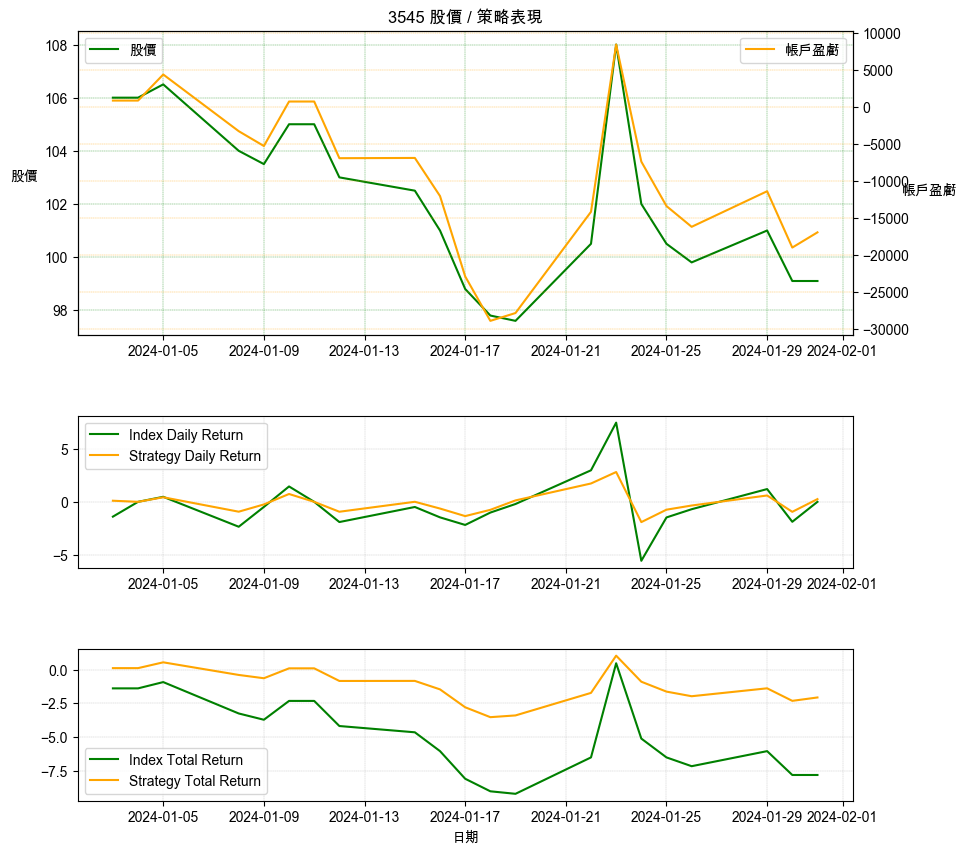

In [10]:
fig, (ax, ax3, ax4) = plt.subplots(nrows=3, figsize=(10,10), gridspec_kw={'height_ratios': [2, 1, 1]}, sharex=False)
ax.plot(df['Close'], color='green')
ax.set_ylabel('股價', rotation=0, labelpad=15)
ax.grid(color='green', linestyle='--', linewidth=0.25)
ax.legend(['股價'], loc=2)

ax2 = ax.twinx()
ax2.plot(strategy01['帳戶盈虧'], color='orange')
ax2.set_ylabel('帳戶盈虧', rotation=0, labelpad=15)
ax2.grid(color='orange', linestyle='--', linewidth=0.25)
ax2.legend(['帳戶盈虧'] ,loc=1)

plt.title(stock+' 股價 / 策略表現')

ax3.plot(strategy01['Index Daily Return (%)'], color='green')
ax3.plot(strategy01['Strategy Daily Return (%)'], color='orange')
ax3.legend(['Index Daily Return', 'Strategy Daily Return'], loc=2)
ax3.grid(linestyle='--', linewidth=0.25)

ax4.plot(strategy01['Index Total Return (%)'], color='green')
ax4.plot(strategy01['Strategy Total Return (%)'], color='orange')
ax4.legend(['Index Total Return', 'Strategy Total Return'])
ax4.grid(linestyle='--', linewidth=0.25)
ax4.set_xlabel('日期')

# 調整圖片之間距離
plt.subplots_adjust(hspace=0.4, wspace=0)
plt.show()

## 已知問題

In [11]:
# 把條件單獨拿出來寫Function讓Code更獨立簡潔
def criteria(close_y, hold, fee_rate, tax_rate, up, down, buy_, sell_, bal, fee_, tax_):
    if down >= 2.5:                                   #跌2.5塊，買1張
        buy_ += 1
        hold += 1
        bal -= 1 * (close_y - 2.5) * 1000             #花費$(close_y-2.5)買1張=1000股
        fee_ += 1 * (close_y - 2.5) * 1000 * fee_rate
    if down >= 6:                                   #跌6塊，買1張
        buy_ += 1
        hold += 1
        bal -= 1 * (close_y - 6) * 1000             #花費$(close_y-6)買1張=1000股
        fee_ += 1 * (close_y - 6) * 1000 * fee_rate
    if down >= 9:                                   #跌9塊，買2張
        buy_ += 2
        hold += 2
        bal -= 2 * (close_y - 9) * 1000             #花費$(close_y-5)買2張=2000股
        fee_ += 2 * (close_y - 9) * 1000 * fee_rate
    if up >= 2.5:                                             #漲2.5塊，賣1張
        sell_ += min(hold, 1)
        bal += min(hold, 1) * (close_y + 2.5) * 1000          #$(close_y+2.5)賣1張=1000股
        fee_ += min(hold, 1) * (close_y + 2.5) * 1000 * fee_rate
        tax_ += min(hold, 1) * (close_y + 2.5) * 1000 * tax_rate
        hold -= min(hold, 1)
    if up >= 6:                                             #漲6塊，賣1張
        sell_ += min(hold, 1)
        bal += min(hold, 1) * (close_y + 6) * 1000          #$(close_y+6)賣1張=1000股
        fee_ += min(hold, 1) * (close_y + 6) * 1000 * fee_rate
        tax_ += min(hold, 1) * (close_y + 6) * 1000 * tax_rate
        hold -= min(hold, 1)
    if up >= 9:                                             #漲9塊，賣2張
        sell_ += min(hold, 2)
        bal += min(hold, 2) * (close_y + 9) * 1000          #$(close_y+9)賣2張=1000股
        fee_ += min(hold, 2) * (close_y + 9) * 1000 * fee_rate
        tax_ += min(hold, 2) * (close_y + 9) * 1000 * tax_rate
        hold -= min(hold, 2)
    return hold, buy_, sell_, bal, fee_, tax_

In [12]:
def strat02(data, init_holding, init_balance, fee_discount):
    df = data
    # 初始持有證券價值
    init_value = init_holding * df.iloc[0,:]['Close'] * 1000
    # 初始持有張數
    holding = [init_holding]
    # 初始資金
    balance = [init_balance]
    # 交易手續費(買、賣價各0.1425%)
    fee_rate = 0.001425 * fee_discount
    # 證交稅(賣出價格0.3%)
    tax_rate = 0.003

    buy, sell, profit, fee, tax, expense, close_value, balance_total  = [], [], [], [], [], [], [], []
    cum_transaction = [0]
    cum_expense = [0]

    for date in df.index:
        #一些變數設置
        hold = holding[-1]
        bal = balance[-1]
        buy_, sell_, fee_, tax_, exp_ = [0, 0, 0, 0, 0]
        high = df.loc[date, 'High']
        close_y = df.loc[date, 'Close_y']
        low = df.loc[date, 'Low']
        up =  high - close_y
        down = close_y - low

        # 執行分析
        analysis = criteria(close_y, hold, fee_rate, tax_rate, up, down, buy_, sell_, bal, fee_, tax_)
        hold, buy_, sell_, bal, fee_, tax_ = analysis[0:6]

        close_val = df.loc[date, 'Close'] * hold * 1000         #計算當日持有股票價值
        trans = buy_ + sell_                                    #計算當日交易量
        exp_ = fee_ + tax_
        bal -= exp_
        bal_tot = bal + close_val
        prof = bal_tot - init_balance - init_value              #計算累積利潤

        # 數據回填
        holding.append(hold)
        balance.append(bal)
        buy.append(buy_)
        sell.append(sell_)
        cum_transaction.append(cum_transaction[-1]+trans)
        close_value.append(close_val)
        fee.append(fee_)
        tax.append(tax_)
        expense.append(exp_)
        cum_expense.append(cum_expense[-1]+exp_)
        balance_total.append(bal_tot)
        profit.append(prof)


    holding = holding[1:]
    balance = balance[1:]
    cum_transaction = cum_transaction[1:]
    cum_expense = cum_expense[1:]

    output = pd.DataFrame(data={'持有股數':holding, '買入':buy, '賣出':sell, '累計交易量': cum_transaction, '收盤價':df['Close'], 
                              '交易手續費': fee, '證交稅': tax, '當日交易成本': expense, '累計交易成本': cum_expense, 
                              '帳戶餘額':balance, '持股收盤價值': close_value, '帳戶總值':balance_total, '帳戶盈虧': profit}, index=df.index)
    output['Index Daily Return (%)'] = df['Return'] * 100
    output['Strategy Daily Return (%)'] = output['帳戶總值'].pct_change() * 100
    output['Strategy Daily Return (%)'].iloc[0] = (output['帳戶總值'].iloc[0] / (init_balance + init_value) - 1) * 100
    output['Index Total Return (%)'] = ((1 + output['Index Daily Return (%)']/100).cumprod() - 1) * 100
    output['Strategy Total Return (%)'] = ((1 + output['Strategy Daily Return (%)']/100).cumprod() - 1) * 100
    return output

In [13]:
strategy02 = strat02(df, 3, 500000, 0.4)
strategy02

/var/folders/dt/b_7_94pn6bqd3dbrpt95_nn80000gn/T/ipykernel_42608/2310044197.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output['Strategy Daily Return (%)'].iloc[0] = (output['帳戶總值'].iloc[0] / (init_balance + init_value) - 1) * 100


,持有股數,買入,賣出,累計交易量,收盤價,交易手續費,證交稅,當日交易成本,累計交易成本,帳戶餘額,持股收盤價值,帳戶總值,帳戶盈虧,Index Daily Return (%),Strategy Daily Return (%),Index Total Return (%),Strategy Total Return (%)
2024-01-03,4,1,0,1,106.0,59.850,0.0,59.850,59.850,394940.150,424000.0,818940.150,940.150,-1.395349,0.114933,-1.395349,0.114933
2024-01-04,4,0,0,1,106.0,0.000,0.0,0.000,59.850,394940.150,424000.0,818940.150,940.150,0.000000,0.000000,-1.395349,0.114933
2024-01-05,3,0,1,2,106.5,61.845,325.5,387.345,447.195,503052.805,319500.0,822552.805,4552.805,0.471698,0.441138,-0.930233,0.556578
2024-01-08,4,1,0,3,104.0,59.280,0.0,59.280,506.475,398993.525,416000.0,814993.525,-3006.475,-2.347418,-0.919002,-3.255814,-0.367540
2024-01-09,4,0,0,3,103.5,0.000,0.0,0.000,506.475,398993.525,414000.0,812993.525,-5006.475,-0.480769,-0.245401,-3.720930,-0.612039
2024-01-10,4,0,0,3,105.0,0.000,0.0,0.000,506.475,398993.525,420000.0,818993.525,993.525,1.449275,0.738013,-2.325581,0.121458
2024-01-11,4,0,0,3,105.0,0.000,0.0,0.000,506.475,398993.525,420000.0,818993.525,993.525,0.000000,0.000000,-2.325581,0.121458
2024-01-12,5,1,0,4,103.0,58.425,0.0,58.425,564.900,296435.100,515000.0,811435.100,-6564.900,-1.904762,-0.922892,-4.186047,-0.802555
2024-01-15,4,0,1,5,102.5,60.135,316.5,376.635,941.535,401558.465,410000.0,811558.465,-6441.535,-0.485437,0.015203,-4.651163,-0.787474
2024-01-16,5,1,0,6,101.0,57.000,0.0,57.000,998.535,301501.465,505000.0,806501.465,-11498.535,-1.463415,-0.623122,-6.046512,-1.405689


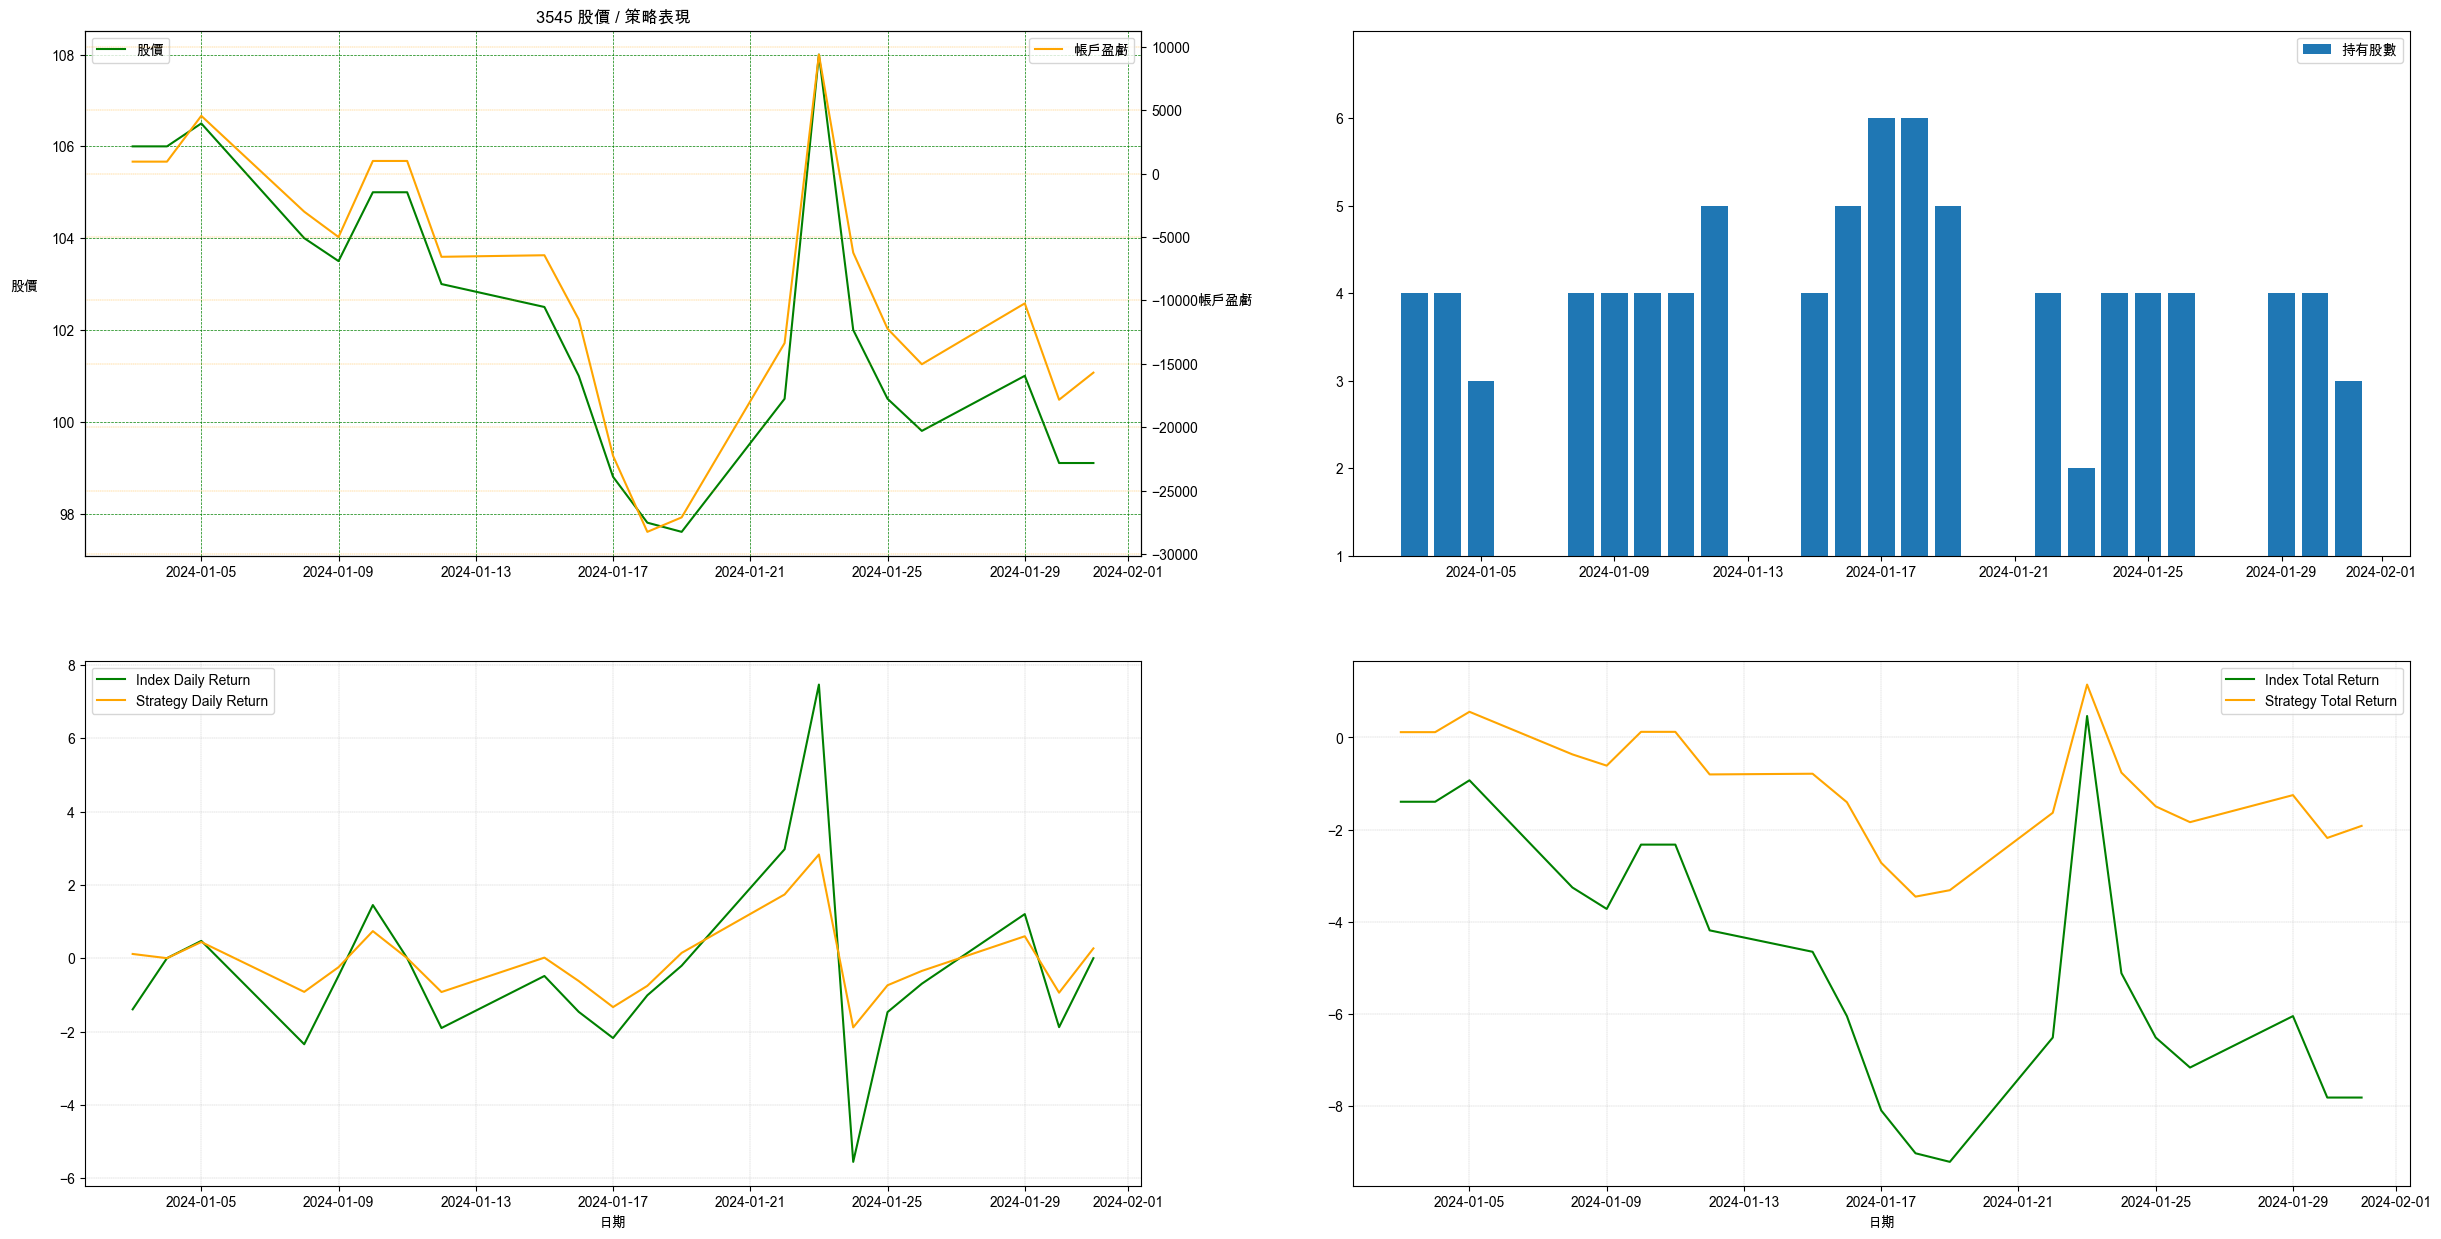

In [14]:
# 多張圖合併
fig, ax = plt.subplots(2, 2, figsize=(30,15), sharex=False)
ax[0,0].plot(df['Close'], color='green')
ax[0,0].set_title(stock+' 股價 / 策略表現')
ax[0,0].set_ylabel('股價', rotation=0, labelpad=20)
ax[0,0].grid(color='green', linestyle='--', linewidth=0.5)
ax[0,0].legend(['股價'], loc=2)

ax2 = ax[0,0].twinx()
ax2.plot(strategy02['帳戶盈虧'], color='orange')
ax2.set_ylabel('帳戶盈虧', rotation=0, labelpad=20)
ax2.grid(color='orange', linestyle='--', linewidth=0.25)
ax2.legend(['帳戶盈虧'] ,loc=1)

ax[0,1].bar(x=strategy02.index, height=strategy02['持有股數'])
ax[0,1].set_yticks(range(0, max(strategy02['持有股數']+1)))
ax[0,1].legend(['持有股數'])
y_min = min([x for x in strategy02['持有股數'] if x != 0]) - 1
y_max = max(strategy02['持有股數']) + 1
ax[0,1].set_ylim(y_min, y_max)

ax[1,0].plot(strategy02['Index Daily Return (%)'], color='green')
ax[1,0].plot(strategy02['Strategy Daily Return (%)'], color='orange')
ax[1,0].legend(['Index Daily Return', 'Strategy Daily Return'], loc=2)
ax[1,0].grid(linestyle='--', linewidth=0.25)
ax[1,0].set_xlabel('日期')

ax[1,1].plot(strategy02['Index Total Return (%)'], color='green')
ax[1,1].plot(strategy02['Strategy Total Return (%)'], color='orange')
ax[1,1].legend(['Index Total Return', 'Strategy Total Return'])
ax[1,1].grid(linestyle='--', linewidth=0.25)
ax[1,1].set_xlabel('日期')

# 調整圖片之間距離
plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.show()

### 將if做成for迴圈，方便給予不同參數

In [15]:
# 把絕對數值改成比例
def criteria(close_y, hold, fee_rate, tax_rate, up, down, buy_, sell_, bal, fee_, tax_, dic_criteria):
    for key, value in dic_criteria.items():
        if key < 0:                                                 #key為負數
            if down >= -key:                                        #跌2.5塊，買1張
                buy_ += value
                hold += value
                fee_ += value * (close_y + key) * 1000 * fee_rate
                bal -= value * (close_y + key) * 1000               #花費$(close_y+key)買1張=1000股
                print('down', 'buy '+str(buy_)+'at $'+str(close_y + key), ',hold '+str(hold), ',bal '+str(bal), ',fee '+str(fee_))
        if key > 0:                                                 #key為正數
            if up >= key:                                           #漲2.5塊，賣1張
                sell_ += min(hold, value)
                fee_ += min(hold, value) * (close_y + key) * 1000 * fee_rate
                tax_ += min(hold, value) * (close_y + key) * 1000 * tax_rate
                bal += min(hold, value) * (close_y + key) * 1000    #$(close_y+2.5)賣1張=1000股
                hold -= min(hold, value)
                print('up,', 'sell '+str(sell_)+'at $'+str(close_y + key), ',hold '+str(hold), ',bal '+str(bal), ',fee '+str(fee_))

    return hold, buy_, sell_, bal, fee_, tax_

In [16]:
test_strat = {2.5:1, 6:1, 9:2, -2.5:1, -6:1, -9:2}
test_strat

{2.5: 1, 6: 1, 9: 2, -2.5: 1, -6: 1, -9: 2}

In [17]:
criteria(106, 5, 0.01425, 0.03, 9, 0, 0, 0, 0, 0, 0, test_strat)

up, sell 1at $108.5 ,hold 4 ,bal 108500.0 ,fee 1546.125
up, sell 2at $112 ,hold 3 ,bal 220500.0 ,fee 3142.125
up, sell 4at $115 ,hold 1 ,bal 450500.0 ,fee 6419.625


(1, 0, 4, 450500.0, 6419.625, 13515.0)

In [18]:
criteria(106, 5, 0.01425, 0.03, 3, 7, 0, 0, 0, 0, 0, test_strat)

up, sell 1at $108.5 ,hold 4 ,bal 108500.0 ,fee 1546.125
down buy 1at $103.5 ,hold 5 ,bal 5000.0 ,fee 3021.0
down buy 2at $100 ,hold 6 ,bal -95000.0 ,fee 4446.0


(6, 2, 1, -95000.0, 4446.0, 3255.0)

In [19]:
def strat03(data, init_holding, init_balance, fee_discount, strat):
    df = data
    # 初始持有證券價值
    init_value = init_holding * df.iloc[0,:]['Close'] * 1000
    # 初始持有張數
    holding = [init_holding]
    # 初始資金
    balance = [init_balance]
    # 交易手續費(買、賣價各0.1425%)
    fee_rate = 0.001425 * fee_discount
    # 證交稅(賣出價格0.3%)
    tax_rate = 0.003

    buy, sell, profit, fee, tax, expense, close_value, balance_total  = [], [], [], [], [], [], [], []
    cum_transaction = [0]
    cum_expense = [0]

    for date in df.index:
        #一些變數設置
        hold = holding[-1]
        bal = balance[-1]
        buy_, sell_, fee_, tax_, exp_ = [0, 0, 0, 0, 0]
        high = df.loc[date, 'High']
        close_y = df.loc[date, 'Close_y']
        low = df.loc[date, 'Low']
        up =  high - close_y
        down = close_y - low

        # 執行分析
        analysis = criteria(close_y, hold, fee_rate, tax_rate, up, down, buy_, sell_, bal, fee_, tax_, strat)
        hold, buy_, sell_, bal, fee_, tax_ = analysis[0:6]

        close_val = df.loc[date, 'Close'] * hold * 1000         #計算當日持有股票價值
        trans = buy_ + sell_                                    #計算當日交易量
        exp_ = fee_ + tax_
        bal -= exp_
        bal_tot = bal + close_val
        prof = bal_tot - init_balance - init_value              #計算累積利潤

        # 數據回填
        holding.append(hold)
        balance.append(bal)
        buy.append(buy_)
        sell.append(sell_)
        cum_transaction.append(cum_transaction[-1]+trans)
        close_value.append(close_val)
        fee.append(fee_)
        tax.append(tax_)
        expense.append(exp_)
        cum_expense.append(cum_expense[-1]+exp_)
        balance_total.append(bal_tot)
        profit.append(prof)
        

    holding = holding[1:]
    balance = balance[1:]
    cum_transaction = cum_transaction[1:]
    cum_expense = cum_expense[1:]

    output = pd.DataFrame(data={'持有股數':holding, '買入':buy, '賣出':sell, '累計交易量': cum_transaction, '收盤價':df['Close'], 
                              '交易手續費': fee, '證交稅': tax, '當日交易成本': expense, '累計交易成本': cum_expense, 
                              '帳戶餘額':balance, '持股收盤價值': close_value, '帳戶總值':balance_total, '帳戶盈虧': profit}, index=df.index)
    output['Index Daily Return (%)'] = df['Return'] * 100
    output['Strategy Daily Return (%)'] = output['帳戶總值'].pct_change() * 100
    output['Strategy Daily Return (%)'].iloc[0] = (output['帳戶總值'].iloc[0] / (init_balance + init_value) - 1) * 100
    output['Index Total Return (%)'] = ((1 + output['Index Daily Return (%)']/100).cumprod() - 1) * 100
    output['Strategy Total Return (%)'] = ((1 + output['Strategy Daily Return (%)']/100).cumprod() - 1) * 100

    return output

In [20]:
strategy03 = strat03(df, 3, 500000, 0.4, test_strat)
strategy03

down buy 1at $105.0 ,hold 4 ,bal 395000.0 ,fee 59.85000000000001
up, sell 1at $108.5 ,hold 3 ,bal 503440.15 ,fee 61.845000000000006
down buy 1at $104.0 ,hold 4 ,bal 399052.80500000005 ,fee 59.28000000000001
down buy 1at $102.5 ,hold 5 ,bal 296493.525 ,fee 58.42500000000001
up, sell 1at $105.5 ,hold 4 ,bal 401935.10000000003 ,fee 60.13500000000001
down buy 1at $100.0 ,hold 5 ,bal 301558.465 ,fee 57.00000000000001
down buy 1at $98.5 ,hold 6 ,bal 203001.46500000003 ,fee 56.14500000000001
up, sell 1at $100.3 ,hold 5 ,bal 303245.32000000007 ,fee 57.17100000000001
up, sell 1at $100.1 ,hold 4 ,bal 402987.24900000007 ,fee 57.05700000000001
up, sell 1at $103.0 ,hold 3 ,bal 505629.89200000005 ,fee 58.71000000000001
up, sell 2at $106.5 ,hold 2 ,bal 612129.892 ,fee 119.41500000000002
down buy 1at $105.5 ,hold 3 ,bal 505881.97699999996 ,fee 60.13500000000001
down buy 2at $102.0 ,hold 4 ,bal 403881.97699999996 ,fee 118.27500000000002
up, sell 1at $101.6 ,hold 3 ,bal 505363.70199999993 ,fee 57.912000

/var/folders/dt/b_7_94pn6bqd3dbrpt95_nn80000gn/T/ipykernel_42608/3846168765.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output['Strategy Daily Return (%)'].iloc[0] = (output['帳戶總值'].iloc[0] / (init_balance + init_value) - 1) * 100


,持有股數,買入,賣出,累計交易量,收盤價,交易手續費,證交稅,當日交易成本,累計交易成本,帳戶餘額,持股收盤價值,帳戶總值,帳戶盈虧,Index Daily Return (%),Strategy Daily Return (%),Index Total Return (%),Strategy Total Return (%)
2024-01-03,4,1,0,1,106.0,59.850,0.0,59.850,59.850,394940.150,424000.0,818940.150,940.150,-1.395349,0.114933,-1.395349,0.114933
2024-01-04,4,0,0,1,106.0,0.000,0.0,0.000,59.850,394940.150,424000.0,818940.150,940.150,0.000000,0.000000,-1.395349,0.114933
2024-01-05,3,0,1,2,106.5,61.845,325.5,387.345,447.195,503052.805,319500.0,822552.805,4552.805,0.471698,0.441138,-0.930233,0.556578
2024-01-08,4,1,0,3,104.0,59.280,0.0,59.280,506.475,398993.525,416000.0,814993.525,-3006.475,-2.347418,-0.919002,-3.255814,-0.367540
2024-01-09,4,0,0,3,103.5,0.000,0.0,0.000,506.475,398993.525,414000.0,812993.525,-5006.475,-0.480769,-0.245401,-3.720930,-0.612039
2024-01-10,4,0,0,3,105.0,0.000,0.0,0.000,506.475,398993.525,420000.0,818993.525,993.525,1.449275,0.738013,-2.325581,0.121458
2024-01-11,4,0,0,3,105.0,0.000,0.0,0.000,506.475,398993.525,420000.0,818993.525,993.525,0.000000,0.000000,-2.325581,0.121458
2024-01-12,5,1,0,4,103.0,58.425,0.0,58.425,564.900,296435.100,515000.0,811435.100,-6564.900,-1.904762,-0.922892,-4.186047,-0.802555
2024-01-15,4,0,1,5,102.5,60.135,316.5,376.635,941.535,401558.465,410000.0,811558.465,-6441.535,-0.485437,0.015203,-4.651163,-0.787474
2024-01-16,5,1,0,6,101.0,57.000,0.0,57.000,998.535,301501.465,505000.0,806501.465,-11498.535,-1.463415,-0.623122,-6.046512,-1.405689


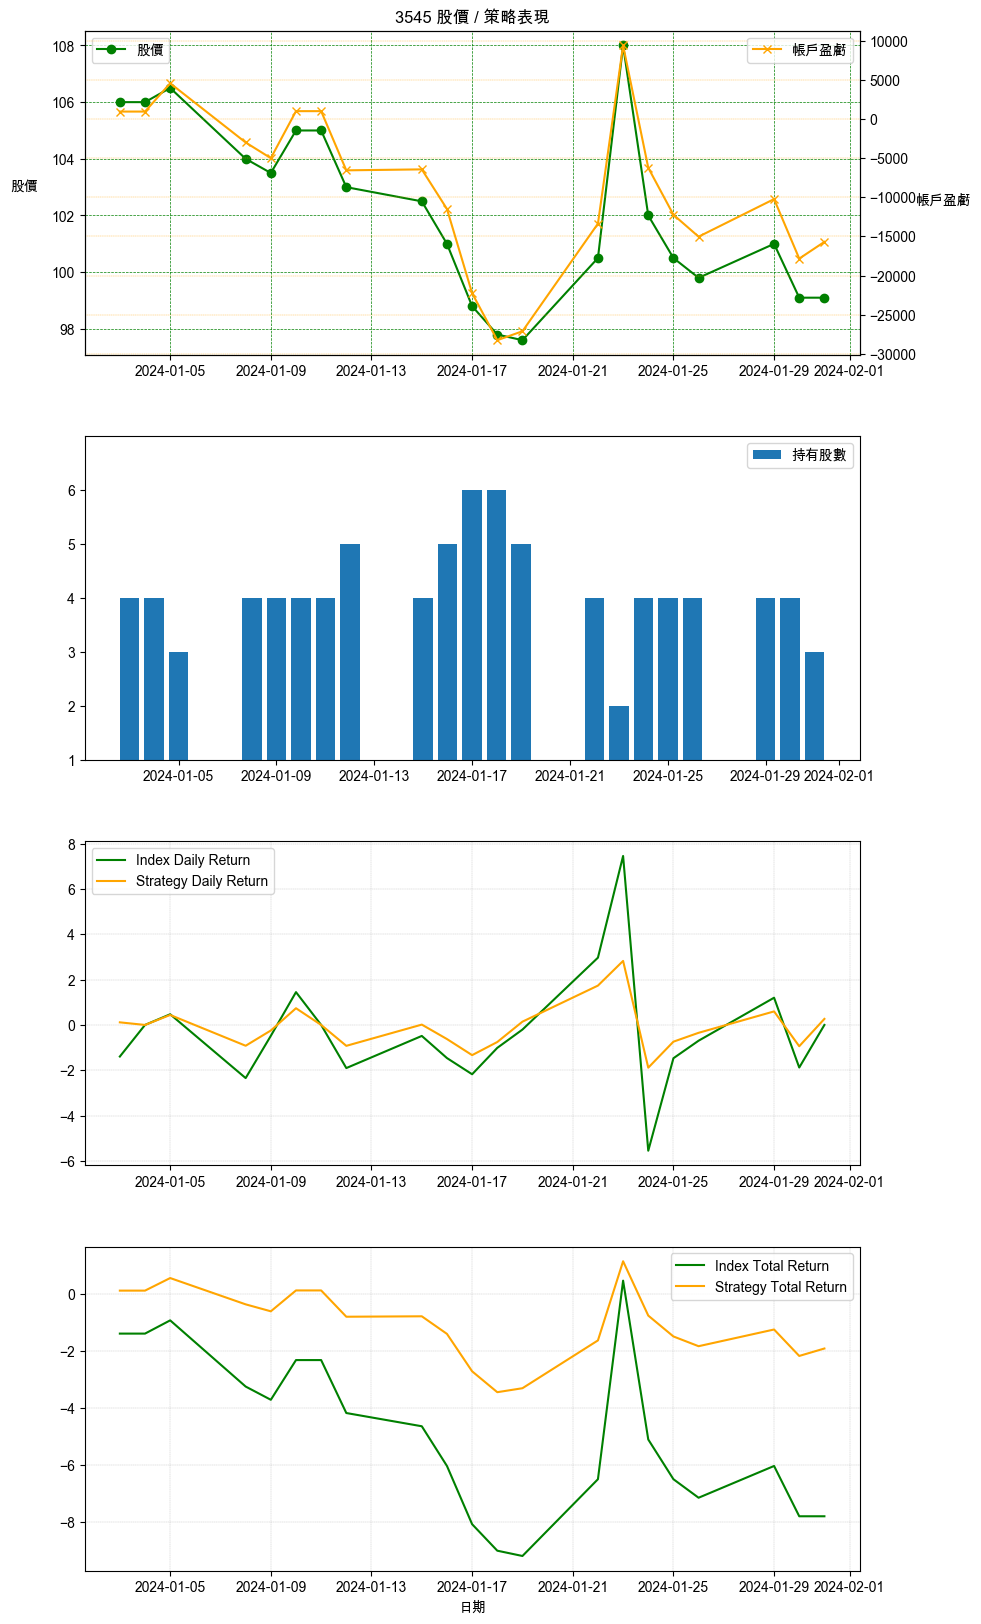

In [21]:
# 多張圖合併
fig, (ax, ax3, ax4, ax5) = plt.subplots(nrows=4, figsize=(10,20), sharex=False)
ax.plot(df['Close'], color='green', marker='o')
ax.set_title(stock+' 股價 / 策略表現')
ax.set_ylabel('股價', rotation=0, labelpad=20)
ax.grid(color='green', linestyle='--', linewidth=0.5)
ax.legend(['股價'], loc=2)


ax2 = ax.twinx()
ax2.plot(strategy03['帳戶盈虧'], color='orange', marker='x')
ax2.set_ylabel('帳戶盈虧', rotation=0, labelpad=20)
ax2.grid(color='orange', linestyle='--', linewidth=0.25)
ax2.legend(['帳戶盈虧'] ,loc=1)


ax3.bar(x=strategy03.index, height=strategy03['持有股數'])
ax3.set_yticks(range(0, max(strategy03['持有股數']+1)))
ax3.legend(['持有股數'])
y_min = min([x for x in strategy03['持有股數'] if x != 0]) - 1
y_max = max(strategy03['持有股數']) + 1
ax3.set_ylim(y_min, y_max)

ax4.plot(strategy03['Index Daily Return (%)'], color='green')
ax4.plot(strategy03['Strategy Daily Return (%)'], color='orange')
ax4.legend(['Index Daily Return', 'Strategy Daily Return'], loc=2)
ax4.grid(linestyle='--', linewidth=0.25)

ax5.plot(strategy03['Index Total Return (%)'], color='green')
ax5.plot(strategy03['Strategy Total Return (%)'], color='orange')
ax5.legend(['Index Total Return', 'Strategy Total Return'])
ax5.grid(linestyle='--', linewidth=0.25)
ax5.set_xlabel('日期')


# 調整圖片之間距離
plt.subplots_adjust(hspace=0.25, wspace=0)
plt.show()

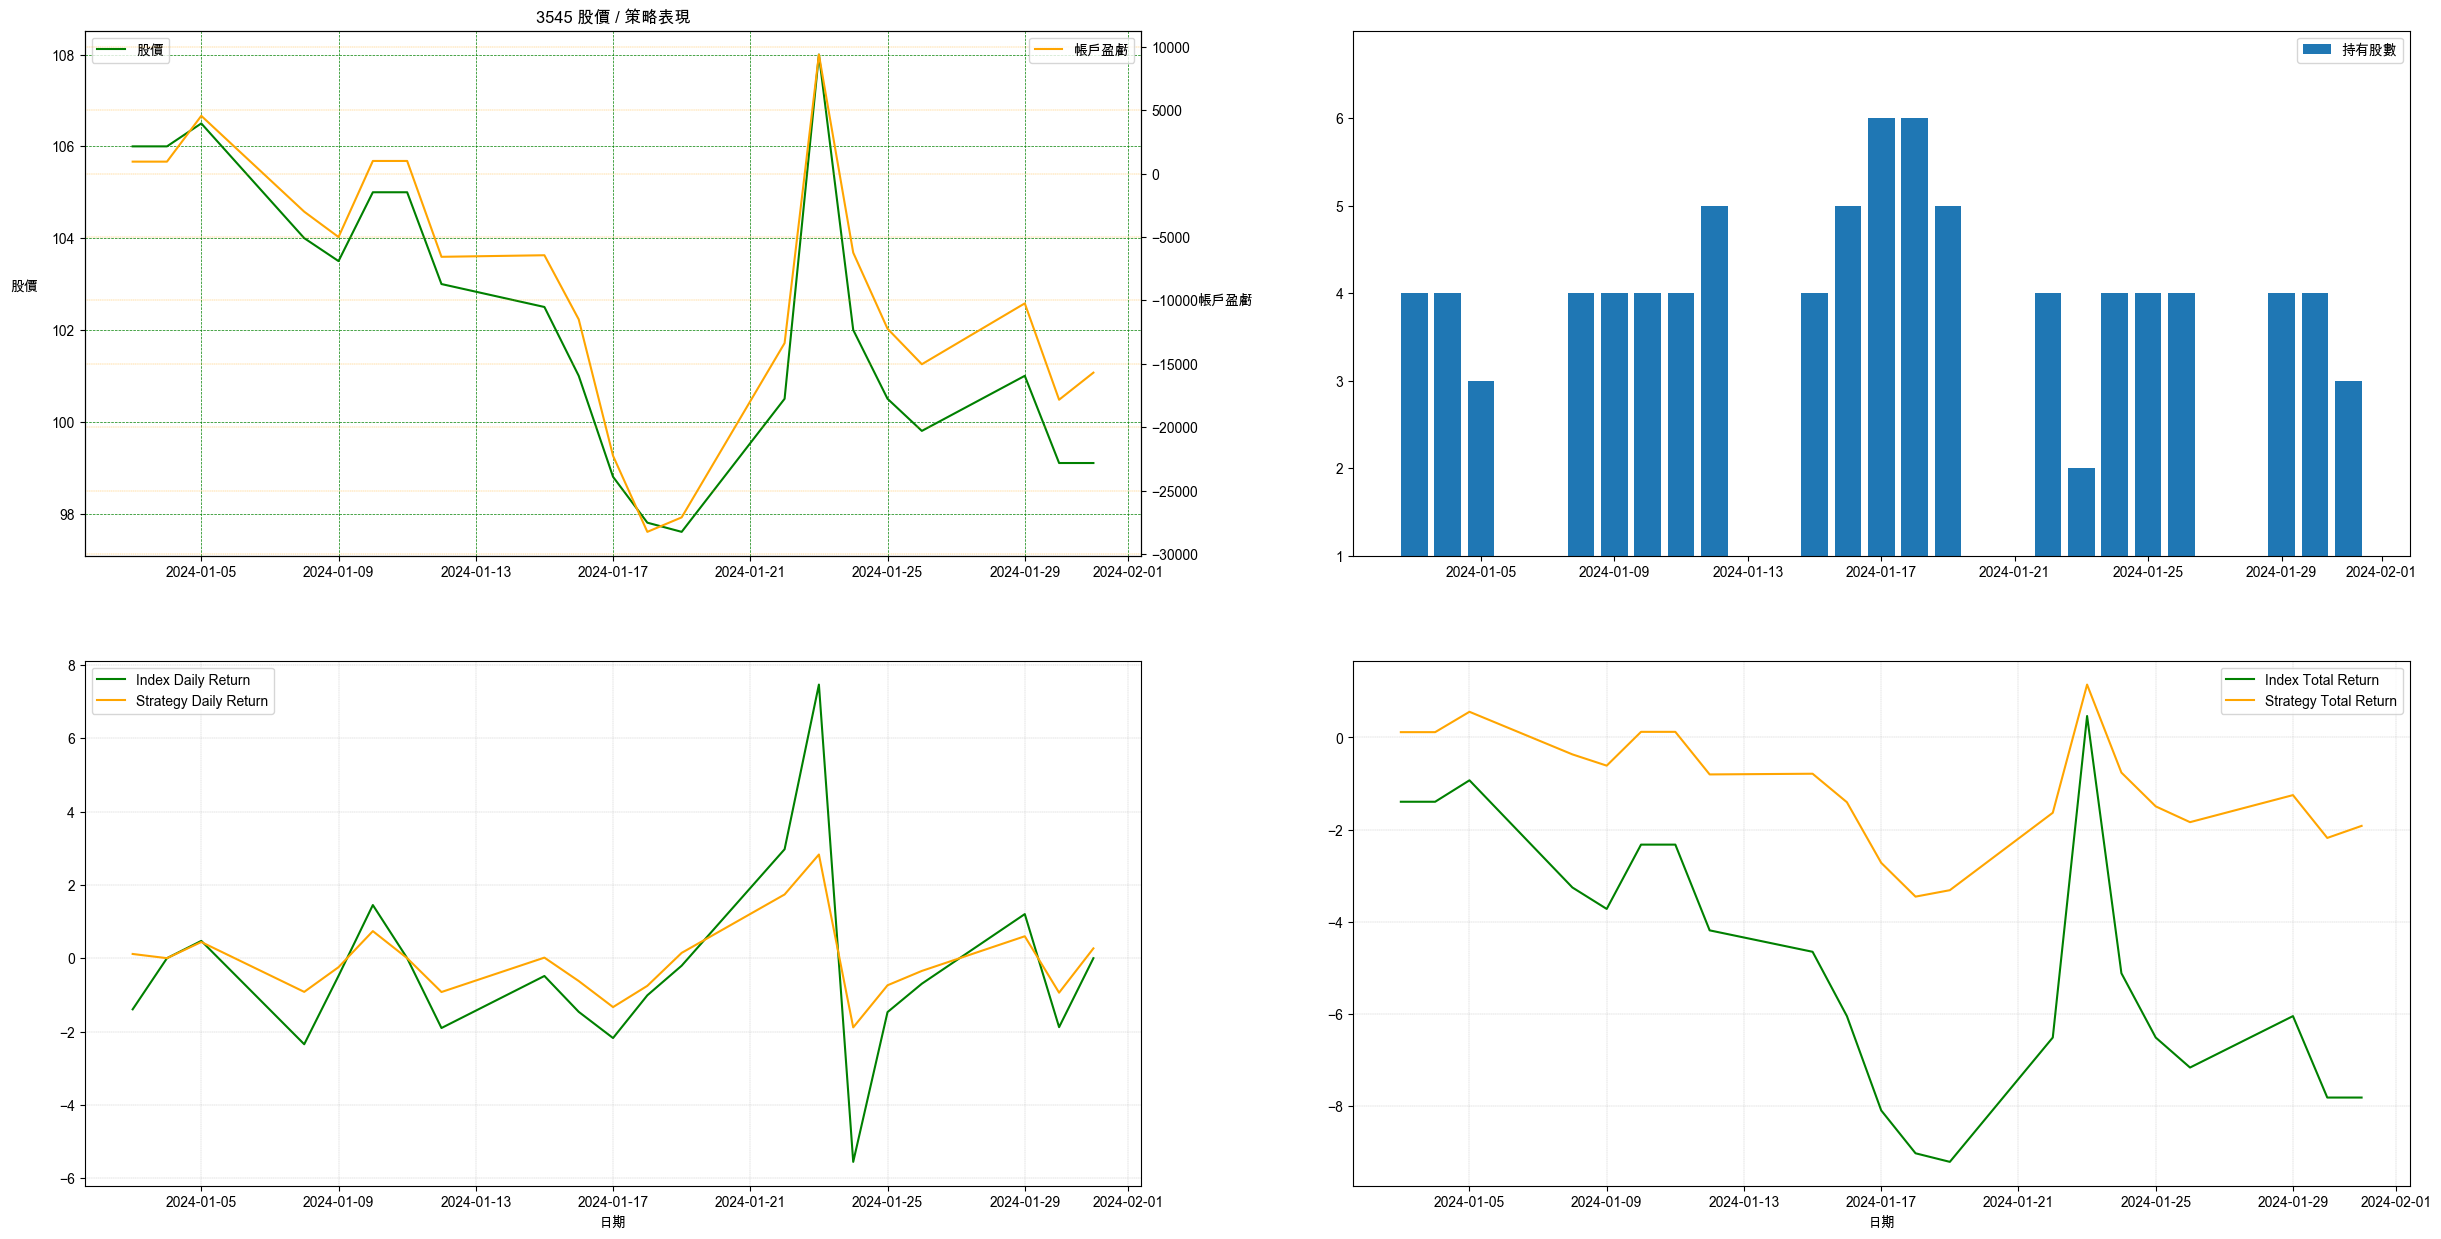

In [22]:
# 多張圖合併
fig, ax = plt.subplots(2, 2, figsize=(30,15), sharex=False)
ax[0,0].plot(df['Close'], color='green')
ax[0,0].set_title(stock+' 股價 / 策略表現')
ax[0,0].set_ylabel('股價', rotation=0, labelpad=20)
ax[0,0].grid(color='green', linestyle='--', linewidth=0.5)
ax[0,0].legend(['股價'], loc=2)

ax2 = ax[0,0].twinx()
ax2.plot(strategy03['帳戶盈虧'], color='orange')
ax2.set_ylabel('帳戶盈虧', rotation=0, labelpad=20)
ax2.grid(color='orange', linestyle='--', linewidth=0.25)
ax2.legend(['帳戶盈虧'] ,loc=1)

ax[0,1].bar(x=strategy03.index, height=strategy03['持有股數'])
ax[0,1].set_yticks(range(0, max(strategy03['持有股數']+1)))
ax[0,1].legend(['持有股數'])
y_min = min([x for x in strategy03['持有股數'] if x != 0]) - 1
y_max = max(strategy03['持有股數']) + 1
ax[0,1].set_ylim(y_min, y_max)

ax[1,0].plot(strategy03['Index Daily Return (%)'], color='green')
ax[1,0].plot(strategy03['Strategy Daily Return (%)'], color='orange')
ax[1,0].legend(['Index Daily Return', 'Strategy Daily Return'], loc=2)
ax[1,0].grid(linestyle='--', linewidth=0.25)
ax[1,0].set_xlabel('日期')

ax[1,1].plot(strategy03['Index Total Return (%)'], color='green')
ax[1,1].plot(strategy03['Strategy Total Return (%)'], color='orange')
ax[1,1].legend(['Index Total Return', 'Strategy Total Return'])
ax[1,1].grid(linestyle='--', linewidth=0.25)
ax[1,1].set_xlabel('日期')

# 調整圖片之間距離
plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.show()

### 把價格變成漲跌比例已適應各價格區間

In [23]:
"""
上漲下跌應以百分比取整數(tick),注意不同價格區間tick不同
0.01 元	10 元以下
0.05 元	10 ~ 50 元
0.10 元	50 ~ 100 元
0.50 元	100 ~ 500 元
1.00 元	500 ~ 1000 元
5.00 元	1,000 元以上
因為手續費跟證交稅也都是百分比,所以區間太小(ex:<2%)容易虧本
"""

'\n上漲下跌應以百分比取整數(tick),注意不同價格區間tick不同\n0.01 元\t10 元以下\n0.05 元\t10 ~ 50 元\n0.10 元\t50 ~ 100 元\n0.50 元\t100 ~ 500 元\n1.00 元\t500 ~ 1000 元\n5.00 元\t1,000 元以上\n因為手續費跟證交稅也都是百分比,所以區間太小(ex:<2%)容易虧本\n'

In [24]:
# tick規則
def tick_rule(price):
    if price < 10:
        tick = 0.01
    elif price < 50:
        tick = 0.05
    elif price < 100:
        tick = 0.1
    elif price < 500:
        tick = 0.5
    elif price < 1000:
        tick = 1
    else:
        tick = 5
    return tick

In [25]:
# 價格換算百分比
# Round the percentage up/down to buy/sell to the nearest tick
def pct2tick(close_y, pct):
    target = close_y * (1 + pct/100)
    tick = tick_rule(target)
    price = round(round(target/tick) * tick, 2)
    return price

In [26]:
# Now the key is in percentage, and value is still the number of stock to buy/sell
test_strat2 = {2.5:1, 5:1, 9:2, -2.5:1, -5:1, -9:2}
test_strat2

{2.5: 1, 5: 1, 9: 2, -2.5: 1, -5: 1, -9: 2}

In [27]:
# 把絕對數值改成比例
def criteria(close_y, hold, fee_rate, tax_rate, up, down, buy_, sell_, bal, fee_, tax_, dic_criteria):

    new_dict = {}
    for key, value in dic_criteria.items():
        newkey = pct2tick(close_y, key)
        new_dict[newkey - close_y] = value

    for key, value in new_dict.items():
        if key < 0:                                                 #key為負數
            if down >= -key:                                        #跌2.5塊，買1張
                buy_ += value
                hold += value
                fee_ += value * (close_y + key) * 1000 * fee_rate
                bal -= value * (close_y + key) * 1000               #花費$(close_y+key)買1張=1000股
                print('down', 'buy '+str(buy_)+'at $'+str(close_y + key), ',hold '+str(hold), ',bal '+str(bal), ',fee '+str(fee_))
        if key > 0:                                                 #key為正數
            if up >= key:                                           #漲2.5塊，賣1張
                sell_ += min(hold, value)
                fee_ += min(hold, value) * (close_y + key) * 1000 * fee_rate
                tax_ += min(hold, value) * (close_y + key) * 1000 * tax_rate
                bal += min(hold, value) * (close_y + key) * 1000    #$(close_y+2.5)賣1張=1000股
                hold -= min(hold, value)
                print('up,', 'sell '+str(sell_)+'at $'+str(close_y + key), ',hold '+str(hold), ',bal '+str(bal), ',fee '+str(fee_))

    return hold, buy_, sell_, bal, fee_, tax_

In [28]:
def strat04(data, init_holding, init_balance, fee_discount, strat):
    df = data
    # 初始持有證券價值
    init_value = init_holding * df.iloc[0,:]['Close'] * 1000
    # 初始持有張數
    holding = [init_holding]
    # 初始資金
    balance = [init_balance]
    # 交易手續費(買、賣價各0.1425%)
    fee_rate = 0.001425 * fee_discount
    # 證交稅(賣出價格0.3%)
    tax_rate = 0.003

    buy, sell, profit, fee, tax, expense, close_value, balance_total  = [], [], [], [], [], [], [], []
    cum_transaction = [0]
    cum_expense = [0]

    for date in df.index:
        #一些變數設置
        hold = holding[-1]
        bal = balance[-1]
        buy_, sell_, fee_, tax_, exp_ = [0, 0, 0, 0, 0]
        high = df.loc[date, 'High']
        close_y = df.loc[date, 'Close_y']
        low = df.loc[date, 'Low']
        up =  high - close_y
        down = close_y - low

        # 執行分析
        analysis = criteria(close_y, hold, fee_rate, tax_rate, up, down, buy_, sell_, bal, fee_, tax_, strat)
        hold, buy_, sell_, bal, fee_, tax_ = analysis[0:6]

        close_val = df.loc[date, 'Close'] * hold * 1000         #計算當日持有股票價值
        trans = buy_ + sell_                                    #計算當日交易量
        exp_ = fee_ + tax_
        bal -= exp_
        bal_tot = bal + close_val
        prof = bal_tot - init_balance - init_value              #計算累積利潤

        # 數據回填
        holding.append(hold)
        balance.append(bal)
        buy.append(buy_)
        sell.append(sell_)
        cum_transaction.append(cum_transaction[-1]+trans)
        close_value.append(close_val)
        fee.append(fee_)
        tax.append(tax_)
        expense.append(exp_)
        cum_expense.append(cum_expense[-1]+exp_)
        balance_total.append(bal_tot)
        profit.append(prof)
        

    holding = holding[1:]
    balance = balance[1:]
    cum_transaction = cum_transaction[1:]
    cum_expense = cum_expense[1:]

    output = pd.DataFrame(data={'持有股數':holding, '買入':buy, '賣出':sell, '累計交易量': cum_transaction, '收盤價':df['Close'], 
                              '交易手續費': fee, '證交稅': tax, '當日交易成本': expense, '累計交易成本': cum_expense, 
                              '帳戶餘額':balance, '持股收盤價值': close_value, '帳戶總值':balance_total, '帳戶盈虧': profit}, index=df.index)
    output['Index Daily Return (%)'] = df['Return'] * 100
    output['Strategy Daily Return (%)'] = output['帳戶總值'].pct_change() * 100
    output['Strategy Daily Return (%)'].iloc[0] = (output['帳戶總值'].iloc[0] / (init_balance + init_value) - 1) * 100
    output['Index Total Return (%)'] = ((1 + output['Index Daily Return (%)']/100).cumprod() - 1) * 100
    output['Strategy Total Return (%)'] = ((1 + output['Strategy Daily Return (%)']/100).cumprod() - 1) * 100

    return output

In [29]:
strategy04 = strat04(df, 3, 500000, 0.4, test_strat2)
strategy04

down buy 1at $105.0 ,hold 4 ,bal 395000.0 ,fee 59.85000000000001
up, sell 1at $108.5 ,hold 3 ,bal 503440.15 ,fee 61.845000000000006
down buy 1at $104.0 ,hold 4 ,bal 399052.80500000005 ,fee 59.28000000000001
down buy 1at $102.5 ,hold 5 ,bal 296493.525 ,fee 58.42500000000001
up, sell 1at $105.5 ,hold 4 ,bal 401935.10000000003 ,fee 60.13500000000001
down buy 1at $98.5 ,hold 5 ,bal 303058.465 ,fee 56.14500000000001
up, sell 1at $100.0 ,hold 4 ,bal 403002.32 ,fee 57.00000000000001
up, sell 1at $100.0 ,hold 3 ,bal 502645.32 ,fee 57.00000000000001
up, sell 1at $103.0 ,hold 2 ,bal 605288.3200000001 ,fee 58.71000000000001
up, sell 2at $105.5 ,hold 1 ,bal 710788.3200000001 ,fee 118.84500000000003
down buy 1at $105.5 ,hold 2 ,bal 604543.9750000001 ,fee 60.13500000000001
down buy 2at $102.5 ,hold 3 ,bal 502043.9750000001 ,fee 118.56000000000003
up, sell 1at $101.5 ,hold 2 ,bal 603425.415 ,fee 57.85500000000001
up, sell 2at $104.0 ,hold 1 ,bal 707425.415 ,fee 117.13500000000002


/var/folders/dt/b_7_94pn6bqd3dbrpt95_nn80000gn/T/ipykernel_42608/3739763560.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output['Strategy Daily Return (%)'].iloc[0] = (output['帳戶總值'].iloc[0] / (init_balance + init_value) - 1) * 100


,持有股數,買入,賣出,累計交易量,收盤價,交易手續費,證交稅,當日交易成本,累計交易成本,帳戶餘額,持股收盤價值,帳戶總值,帳戶盈虧,Index Daily Return (%),Strategy Daily Return (%),Index Total Return (%),Strategy Total Return (%)
2024-01-03,4,1,0,1,106.0,59.850,0.0,59.850,59.850,394940.150,424000.0,818940.150,940.150,-1.395349,0.114933,-1.395349,0.114933
2024-01-04,4,0,0,1,106.0,0.000,0.0,0.000,59.850,394940.150,424000.0,818940.150,940.150,0.000000,0.000000,-1.395349,0.114933
2024-01-05,3,0,1,2,106.5,61.845,325.5,387.345,447.195,503052.805,319500.0,822552.805,4552.805,0.471698,0.441138,-0.930233,0.556578
2024-01-08,4,1,0,3,104.0,59.280,0.0,59.280,506.475,398993.525,416000.0,814993.525,-3006.475,-2.347418,-0.919002,-3.255814,-0.367540
2024-01-09,4,0,0,3,103.5,0.000,0.0,0.000,506.475,398993.525,414000.0,812993.525,-5006.475,-0.480769,-0.245401,-3.720930,-0.612039
2024-01-10,4,0,0,3,105.0,0.000,0.0,0.000,506.475,398993.525,420000.0,818993.525,993.525,1.449275,0.738013,-2.325581,0.121458
2024-01-11,4,0,0,3,105.0,0.000,0.0,0.000,506.475,398993.525,420000.0,818993.525,993.525,0.000000,0.000000,-2.325581,0.121458
2024-01-12,5,1,0,4,103.0,58.425,0.0,58.425,564.900,296435.100,515000.0,811435.100,-6564.900,-1.904762,-0.922892,-4.186047,-0.802555
2024-01-15,4,0,1,5,102.5,60.135,316.5,376.635,941.535,401558.465,410000.0,811558.465,-6441.535,-0.485437,0.015203,-4.651163,-0.787474
2024-01-16,4,0,0,5,101.0,0.000,0.0,0.000,941.535,401558.465,404000.0,805558.465,-12441.535,-1.463415,-0.739318,-6.046512,-1.520970


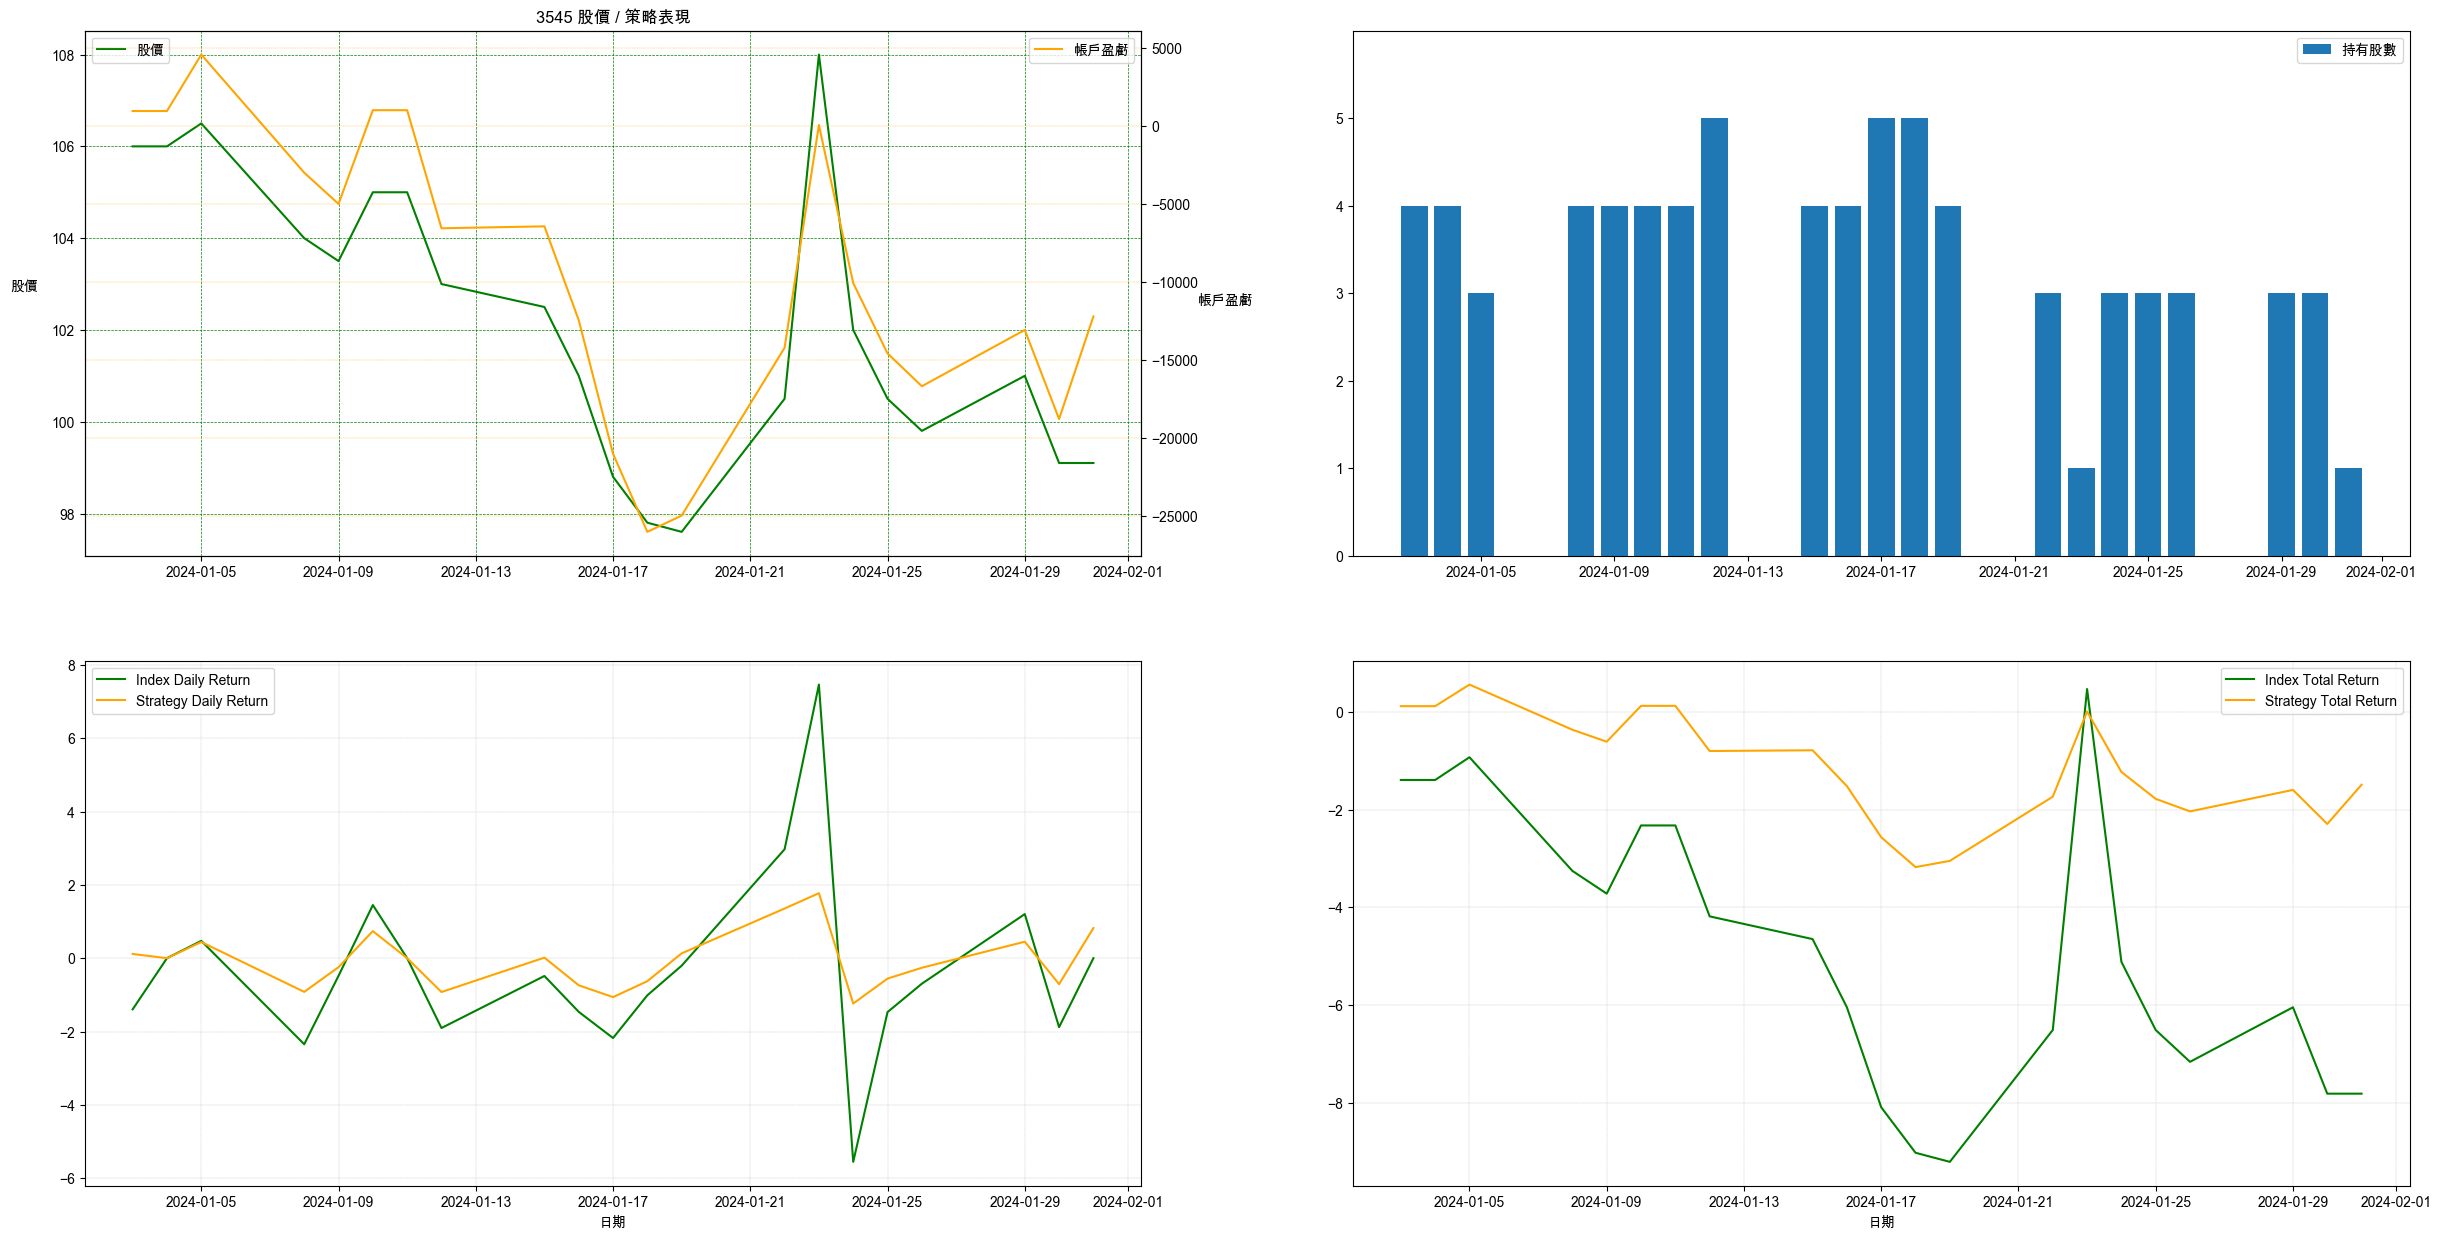

In [30]:
# 多張圖合併
fig, ax = plt.subplots(2, 2, figsize=(30,15), sharex=False)
ax[0,0].plot(df['Close'], color='green')
ax[0,0].set_title(stock+' 股價 / 策略表現')
ax[0,0].set_ylabel('股價', rotation=0, labelpad=20)
ax[0,0].grid(color='green', linestyle='--', linewidth=0.5)
ax[0,0].legend(['股價'], loc=2)

ax2 = ax[0,0].twinx()
ax2.plot(strategy04['帳戶盈虧'], color='orange')
ax2.set_ylabel('帳戶盈虧', rotation=0, labelpad=20)
ax2.grid(color='orange', linestyle='--', linewidth=0.25)
ax2.legend(['帳戶盈虧'] ,loc=1)

ax[0,1].bar(x=strategy04.index, height=strategy04['持有股數'])
ax[0,1].set_yticks(range(0, max(strategy04['持有股數']+1)))
ax[0,1].legend(['持有股數'])
y_min = min([x for x in strategy04['持有股數'] if x != 0]) - 1
y_max = max(strategy04['持有股數']) + 1
ax[0,1].set_ylim(y_min, y_max)

ax[1,0].plot(strategy04['Index Daily Return (%)'], color='green')
ax[1,0].plot(strategy04['Strategy Daily Return (%)'], color='orange')
ax[1,0].legend(['Index Daily Return', 'Strategy Daily Return'], loc=2)
ax[1,0].grid(linestyle='--', linewidth=0.25)
ax[1,0].set_xlabel('日期')

ax[1,1].plot(strategy04['Index Total Return (%)'], color='green')
ax[1,1].plot(strategy04['Strategy Total Return (%)'], color='orange')
ax[1,1].legend(['Index Total Return', 'Strategy Total Return'])
ax[1,1].grid(linestyle='--', linewidth=0.25)
ax[1,1].set_xlabel('日期')

# 調整圖片之間距離
plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.show()